##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer Position Encoding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/position_encoding.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

See [this notebook](https://github.com/site/en/r2/tutorials/sequences/transformer.ipynb) for a walk-through of full transformer implementation.

The transformer architecture uses stacked attention layers in place of CNNs or RNNs. This makes it easy to learn long-range dependencise but it contains no built in information about the relative positions of items in a sequence. 

To give the model access to this information the transformer architecture uses adda a position encoding to the input.

This endocing is a vector of sines and cosines at each position, where each sine-cosine pair rotates at a different frequency.  

Nearby locations will have similar position-encoding vectors.

## Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt

The angle rates range from `1 [rads/step]` to `min_rate [rads/step]` over the vector depth.

Formula for angle rate:

$$angle\_rate_d = (min\_rate)^{d / d_{max}} $$

In [3]:
num_positions = 50
depth = 512
min_rate = 1/10000

assert depth%2 == 0, "Depth must be even."
angle_rate_exponents = np.linspace(0,1,depth//2)
angle_rates = min_rate**(angle_rate_exponents)

The resulting exponent goes from `0` to `1`, causing the `angle_rates` to drop exponentially from `1` to `min_rate`.

Text(0, 0.5, 'Angle rate [rads/step]')

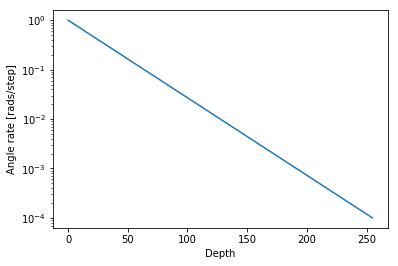

In [4]:
plt.semilogy(angle_rates)
plt.xlabel('Depth')
plt.ylabel('Angle rate [rads/step]')

Broadcasting a multiply over angle rates and positions gives a map of the position encoding angles as a function of depth.

In [29]:
positions = np.arange(num_positions) 
angle_rads = (positions[:, np.newaxis])*angle_rates[np.newaxis, :]

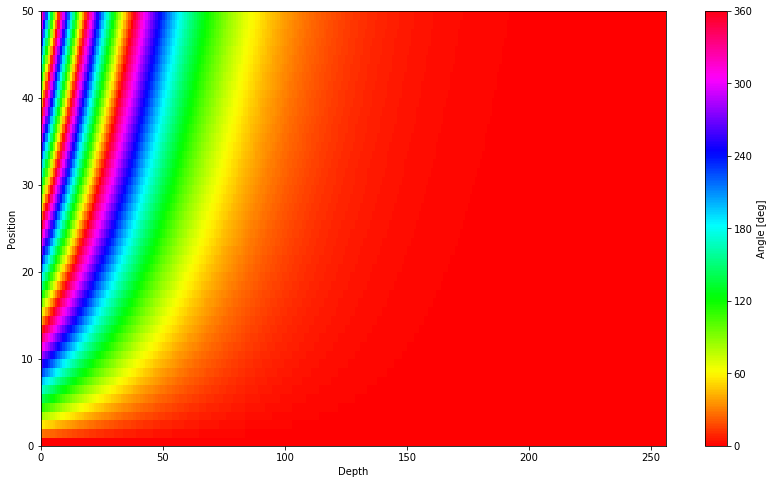

In [6]:
plt.figure(figsize = (14,8))
plt.pcolormesh(
    # Convert to degrees, and wrap around at 360
    angle_rads*180/(2*np.pi) % 360,
    # Use a cyclical colormap so that color(0) == color(360)
    cmap='hsv', vmin=0, vmax=360)

plt.xlim([0,len(angle_rates)])
plt.ylabel('Position')
plt.xlabel('Depth')
bar = plt.colorbar(label='Angle [deg]')
bar.set_ticks(np.linspace(0,360,6+1))

Raw angles are not a good model input (they're either unbounded, or discontinuous). So take the sine and cosine:

In [30]:
sines = np.sin(angle_rads)
cosines = np.cos(angle_rads)

pos_encoding = np.concatenate([sines, cosines], axis=-1)

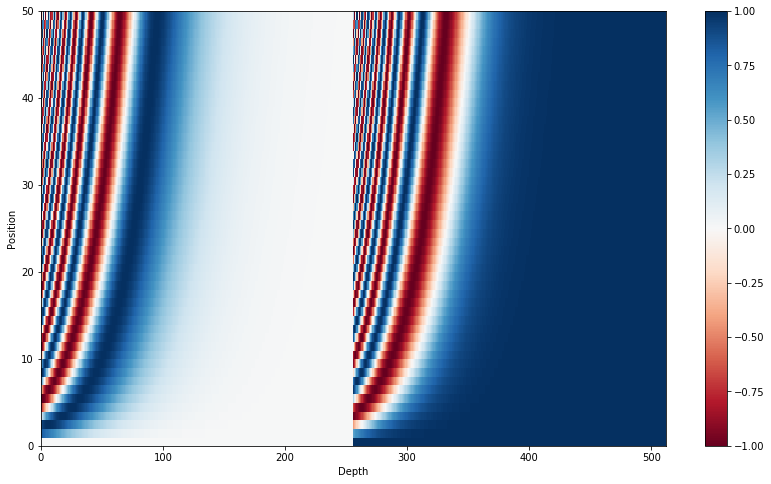

In [31]:
plt.figure(figsize=(14,8))
plt.pcolormesh(pos_encoding, 
               # Use a diverging colormap so it's clear where zero is.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()

## Nearby positions

Nearby locations will have similar position-encoding vectors. 

To demonstrate compare one position's encoding (here position 20) with each of the others:

In [21]:
pos_encoding_at_20 = pos_encoding[20]
print(pos_encoding.shape)
print(pos_encoding[20].shape)
dots = np.dot(pos_encoding,pos_encoding_at_20)
print(dots.shape)
SSE = np.sum((pos_encoding - pos_encoding_at_20)**2, axis=1)

(50, 512)
(512,)
(50,)


Regardless of how you compare the vecors, they are most similar 20, and clearly diverge as you move away: 

Text(0.5, 0, 'Position')

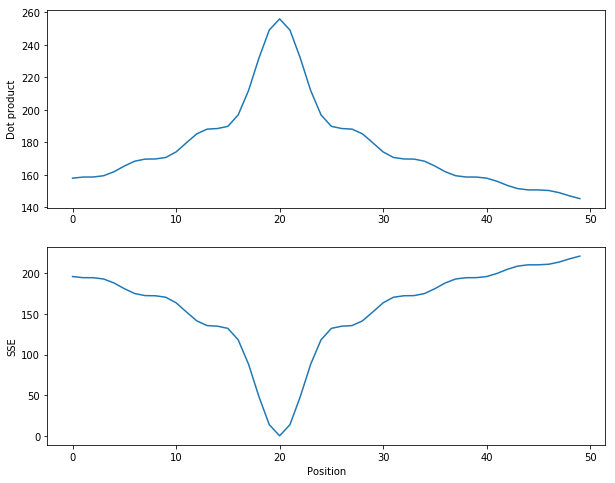

In [10]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylabel('Dot product')
plt.subplot(2,1,2)
plt.plot(SSE)
plt.ylabel('SSE')
plt.xlabel('Position')


## Relative positions

The [paper](https://arxiv.org/pdf/1706.03762.pdf) explains, at the end of section 3.5, that any relative position encoding can be written as a linear function of the current position.

To demonstrate, this section builds a matrix that calculates these relative position encodings. 

In [11]:
def transition_matrix(position_delta, angle_rates = angle_rates):
  # Implement as a matrix multiply:
  #    sin(a+b) = sin(a)*cos(b)+cos(a)*sin(b)
  #    cos(a+b) = cos(a)*cos(b)-sin(a)*sin(b)
  
  # b
  angle_delta = position_delta*angle_rates

  # sin(b), cos(b)
  sin_delta = np.sin(angle_delta)
  cos_delta = np.cos(angle_delta)

  I = np.eye(len(angle_rates))
  
  # sin(a+b) = sin(a)*cos(b)+cos(a)*sin(b)
  update_sin = np.concatenate([I*cos_delta, I*sin_delta], axis=0)
  
  # cos(a+b) = cos(a)*cos(b)-sin(a)*sin(b)
  update_cos = np.concatenate([-I*sin_delta, I*cos_delta], axis=0)

  return np.concatenate([update_sin, update_cos], axis=-1)

For example, create the matrix that calculates the position encoding 10 steps back, from the current position encoding:

In [12]:
position_delta = -10
update = transition_matrix(position_delta)

Applying this matrix to each position encoding vector gives position encoding vector from -10 steps away, resulting in a shifted position-encoding map:

Text(0.5, 0, 'Depth')

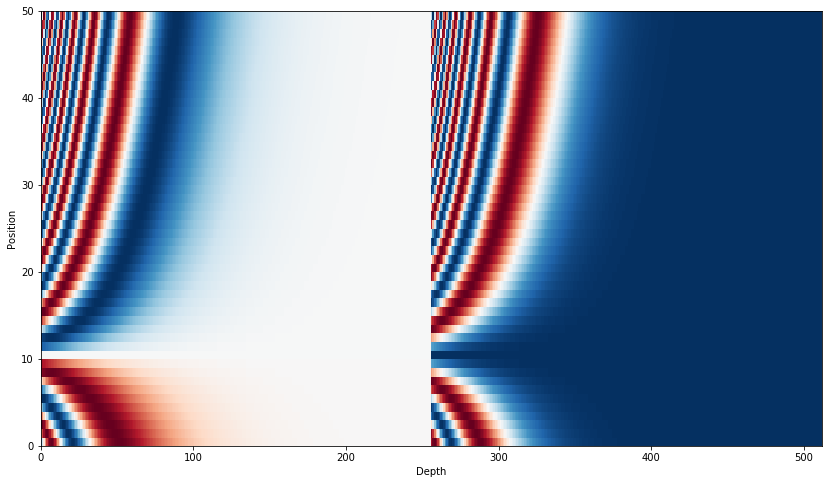

In [13]:
plt.figure(figsize=(14,8))
plt.pcolormesh(np.dot(pos_encoding,update), cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')

This is accurate to numerical precision.

In [14]:
errors = np.dot(pos_encoding,update)[10:] - pos_encoding[:-10]
abs(errors).max()

5.4262150328554526e-15